# Variational Quantum Eigensolver - Ground State Energy for $H2$ Molecule using the A ansatz

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, IBMQ, QuantumRegister, ClassicalRegister

from qiskit.tools.jupyter import *

from qiskit.visualization import *

from ibm_quantum_widgets import *

from qiskit.providers.aer import QasmSimulator, StatevectorSimulator

from qiskit.utils import QuantumInstance

from qiskit.circuit import Parameter

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
# Chemistry Drivers
from qiskit_nature.drivers.second_quantization.pyscfd import PySCFDriver

from qiskit_nature.transformers.second_quantization.electronic import FreezeCoreTransformer

from qiskit.opflow.primitive_ops import Z2Symmetries

# Electroinic structure problem
from qiskit_nature.problems.second_quantization.electronic import ElectronicStructureProblem

# Qubit converter
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

# Mappers
from qiskit_nature.mappers.second_quantization import ParityMapper, BravyiKitaevMapper, JordanWignerMapper

# Initial state
from qiskit_nature.circuit.library import HartreeFock

# Variational form - circuit
from qiskit.circuit.library import TwoLocal

# Optimizer
from qiskit.algorithms.optimizers import COBYLA, SLSQP, SPSA

# Algorithms and Factories
from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

# Eigen Solvers
# NumPy Minimum Eigen Solver
from qiskit_nature.algorithms.ground_state_solvers.minimum_eigensolver_factories import NumPyMinimumEigensolverFactory
# ground state
from qiskit_nature.algorithms.ground_state_solvers import GroundStateEigensolver
# VQE Solver
from qiskit.algorithms import VQE

Backend

In [5]:
qasm_sim = QasmSimulator()
state_sim = StatevectorSimulator()

Drivers

Below we set up a PySCF driver for $H2$ molecule at equilibrium bond length 0.735 Angstrom

In [6]:
def exact_diagonalizer(es_problem, qubit_converter):
    solver = NumPyMinimumEigensolverFactory()
    calc = GroundStateEigensolver(qubit_converter, solver)
    result = calc.solve(es_problem)
    return result

In [7]:
def get_mapper(mapper_str: str):
    if mapper_str == "jw":
        mapper = JordanWignerMapper()
    elif mapper_str == "pa":
        mapper = ParityMapper()
    elif mapper_str == "bk":
        mapper = BravyiKitaevMapper()
        
    return mapper

In [8]:
def initial_state_preparation(dist: float, mapper_str: str = "pa"):
    
    molecule = "H 0.0 0.0 0.0; H 0.0 0.0 " + str(dist)
    driver = PySCFDriver(atom=molecule)
    qmolecule = driver.run()
    
    transformer = FreezeCoreTransformer()
    qmolecule = transformer.transform(qmolecule)
    es_problem = ElectronicStructureProblem(driver)
    
    # generating second_quzntized operators
    second_q_ops = es_problem.second_q_ops()
    
    # Hamiltonian
    main_op = second_q_ops[0]
    
    # return tuple of number of particles if available
    num_particles = es_problem.num_particles
    # return the number of spin orbitals
    num_spin_orbitals = es_problem.num_spin_orbitals
    
    mapper = get_mapper(mapper_str)
    
    qubit_converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)#, z2symmetry_reduction=[1, 1])
    
    # Qubit Hamiltonian
    qubit_op = qubit_converter.convert(main_op, num_particles=num_particles)
    
    return (qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem)

In [9]:
inter_atomic_dists: list = np.arange(0.720, 0.750, 0.005)

In [86]:
numpy_eigensolver_electronic_ground_energies: list = []
numpy_eigensolver_nuclear_repulsion_energies: list = []
numpy_eigensolver_total_ground_state_energies: list = []

from qiskit_nature.algorithms import ExcitedStatesEigensolver, NumPyEigensolverFactory

print("Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm\n")

for dist in inter_atomic_dists:
    qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "pa")
    # construct NumPyEigensolver - solver algorithm
    numpy_solver = NumPyEigensolverFactory(use_default_filter_criterion=True)
    # calculate excited states using the NumPyEigensolver solver algorithm
    numpy_excited_states_calculation = ExcitedStatesEigensolver(qubit_converter, numpy_solver)
    # Compute Ground and Excited States properties.
    numpy_ground_excited_states_properties = numpy_excited_states_calculation.solve(es_problem)
    
    # Get Repulsion energy from properties of ground and excited states
    nuclear_repulsion_energy = numpy_ground_excited_states_properties.nuclear_repulsion_energy
    numpy_eigensolver_nuclear_repulsion_energies.append(nuclear_repulsion_energy)
    
    # constructs NumPyMinimumEigensolver - solver algorithm
    numpy_minimum_solver = NumPyMinimumEigensolverFactory()
    # compute the ground state using a minimum eigensolver
    numpy_ground_state_calculation = GroundStateEigensolver(qubit_converter, numpy_minimum_solver)
    # Compute Ground state properties - returns an Eigenstate result
    numpy_ground_state_properties = numpy_ground_state_calculation.solve(es_problem)
    
    # Get electronic ground state energies
    electronic_ground_energy = np.real(numpy_ground_state_properties.eigenenergies[0])
    numpy_eigensolver_electronic_ground_energies.append(electronic_ground_energy)
    
    # Get the total ground state energy
    total_ground_state_energy = (electronic_ground_energy + nuclear_repulsion_energy)
    numpy_eigensolver_total_ground_state_energies.append(total_ground_state_energy)
    
    print("Interatomic dist: {:.4f} Å \t Electronic Ground Energy: {:.4f} Eh \t Nuclear Repulsion Energy: {:.4f} Eh \tTotal Ground State Energy: {:.4f} Eh".format(dist, electronic_ground_energy, nuclear_repulsion_energy, total_ground_state_energy))
    # print("Interatomic dist: {:.4f} Å \t Total Ground State Energy: {:.4f} Eh".format(dist, total_ground_state_energy))
    

Total Ground State Energies of H2 Molecule using NumPyMinimumEigensolver algorithm

Interatomic dist: 0.7200 Å 	 Electronic Ground Energy: -1.8721 Eh 	 Nuclear Repulsion Energy: 0.7350 Eh 	Total Ground State Energy: -1.1371 Eh
Interatomic dist: 0.7250 Å 	 Electronic Ground Energy: -1.8671 Eh 	 Nuclear Repulsion Energy: 0.7299 Eh 	Total Ground State Energy: -1.1372 Eh
Interatomic dist: 0.7300 Å 	 Electronic Ground Energy: -1.8622 Eh 	 Nuclear Repulsion Energy: 0.7249 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7350 Å 	 Electronic Ground Energy: -1.8573 Eh 	 Nuclear Repulsion Energy: 0.7200 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7400 Å 	 Electronic Ground Energy: -1.8524 Eh 	 Nuclear Repulsion Energy: 0.7151 Eh 	Total Ground State Energy: -1.1373 Eh
Interatomic dist: 0.7450 Å 	 Electronic Ground Energy: -1.8475 Eh 	 Nuclear Repulsion Energy: 0.7103 Eh 	Total Ground State Energy: -1.1372 Eh
Interatomic dist: 0.7500 Å 	 Electronic Ground Energy: -1.

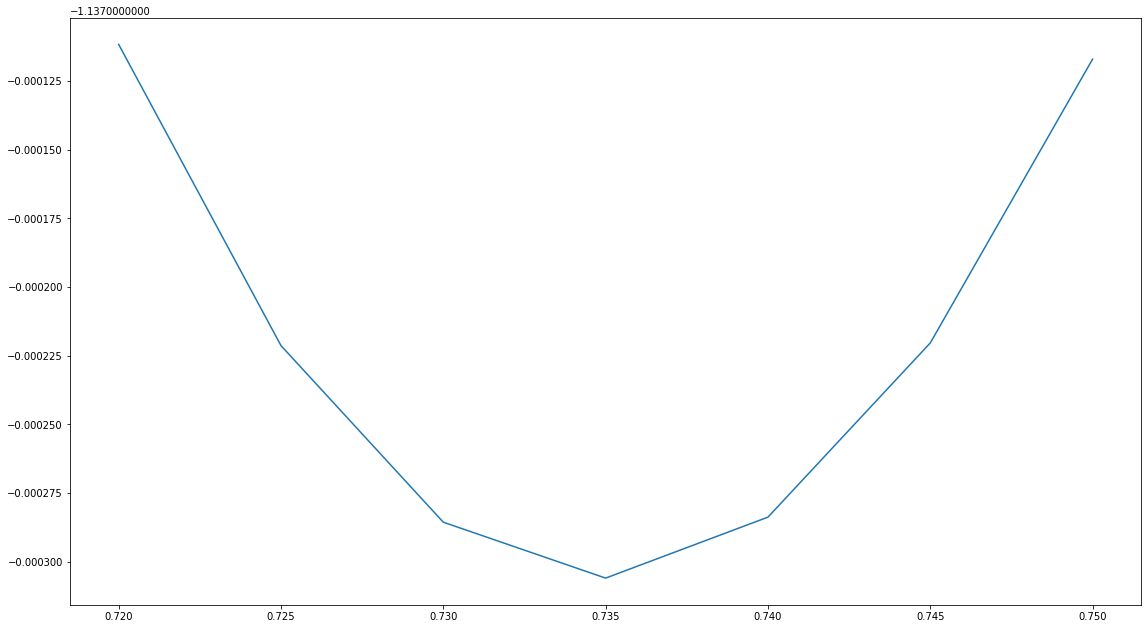

In [87]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.show()

In [20]:
def A_ansatz(qubit_op, init_state):
    theta = Parameter("t")
    phi = Parameter("p")

    R = QuantumCircuit(1, name="$R(\\theta, \phi)$")
    R.ry(theta + (0.5 * np.pi), 0)
    R.rz(phi + np.pi, 0)

    Rd = QuantumCircuit(1, name="$R(\\theta, \phi)^\dagger$")
    Rd.ry(theta + (0.5 * np.pi), 0).inverse()
    Rd.rz(phi + np.pi, 0).inverse()

    a_var_form = QuantumCircuit(2)#qubit_op.num_qubits)
    a_var_form.cx(1, 0)
    a_var_form.append(Rd, [1])
    a_var_form.cx(0, 1)
    a_var_form.append(R, [1])
    a_var_form.cx(1, 0)

    ansatz = TwoLocal(
        num_qubits = qubit_op.num_qubits,
        rotation_blocks = [ a_var_form ],
        entanglement_blocks = [ a_var_form ],
        entanglement = [[1, 2]],
        reps=2,
        skip_unentangled_qubits = False,
        skip_final_rotation_layer = True,
        # parameter_prefix = theta,
        insert_barriers = True,
        # initial_state = init_state,
        name = "$A(\\theta, \phi)$"
    )

    ansatz.compose(init_state, front=True, inplace=True)
    return ansatz

In [21]:
a_total_ground_state_energies: list = []

from IPython.display import display, clear_output

def callback(eval_count, parameters, mean, std):
    # overwrites same line when printing
    display("Evaluation: {},\tEnergy: {},\tStd: {}".format(eval_count, mean, std))
    clear_output(wait=True)
    counts.append(eval_count)
    values.append(mean)
    params.append(parameters)
    deviation.append(std)
    
counts = []
values = []
params = []
deviation = []

ansatz = 0

backend = state_sim#Aer.get_backend("aer_simulator_statevector")
quantum_instance = QuantumInstance(backend=backend)#Aer.get_backend("aer_simulator_statevector"))
optimizer = COBYLA(maxiter=10000)
# optimizer = SLSQP(maxiter=5)

# for dist in inter_atomic_dists:
dist = 0.735
qubit_op, num_particles, num_spin_orbitals, qubit_converter, es_problem = initial_state_preparation(dist, "jw")

init_state = HartreeFock(num_spin_orbitals, num_particles, qubit_converter)

ansatz = A_ansatz(qubit_op, init_state)

try:
    initial_point = [0.01] * len(ansatz.ordered_parameters)
except:
    initial_point = [0.01] * ansatz.num_parameters

vqe_solver = VQE(
    ansatz=ansatz,
    optimizer=optimizer,
    initial_point=initial_point,
    callback=callback,
    quantum_instance=quantum_instance,
)

result = vqe_solver.compute_minimum_eigenvalue(qubit_op)
a_total_ground_state_energies.append( np.real(result.eigenvalue) )
print(result.aux_operator_eigenvalues, min(values), "===\n", result)
    # values.clear()

None -1.8572746128871407 ===
 {   'aux_operator_eigenvalues': None,
    'cost_function_evals': 869,
    'eigenstate': array([ 3.26990282e-05+3.03445554e-04j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  7.83708305e-05-1.92839939e-04j,
        0.00000000e+00+0.00000000e+00j,  9.92905654e-01-4.11648718e-02j,
        2.31274085e-05+6.61752334e-05j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  9.59969514e-06-5.55326355e-06j,
       -1.11457579e-01+4.53882617e-03j,  0.00000000e+00+0.00000000e+00j,
        5.02387520e-04+3.04794039e-05j,  0.00000000e+00+0.00000000e+00j,
        0.00000000e+00+0.00000000e+00j,  7.33708553e-06-1.64426906e-04j]),
    'eigenvalue': (-1.8572746042113026+0j),
    'optimal_parameters': {   ParameterVectorElement(θ[7]): -0.21957222282931046,
                              ParameterVectorElement(θ[9]): 0.22020510759302817,
                              ParameterVectorElement(θ[10]): 0.0015452371167787983,
     

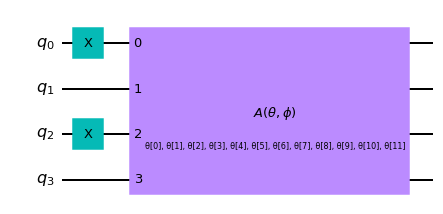

In [22]:
ansatz.draw("mpl")

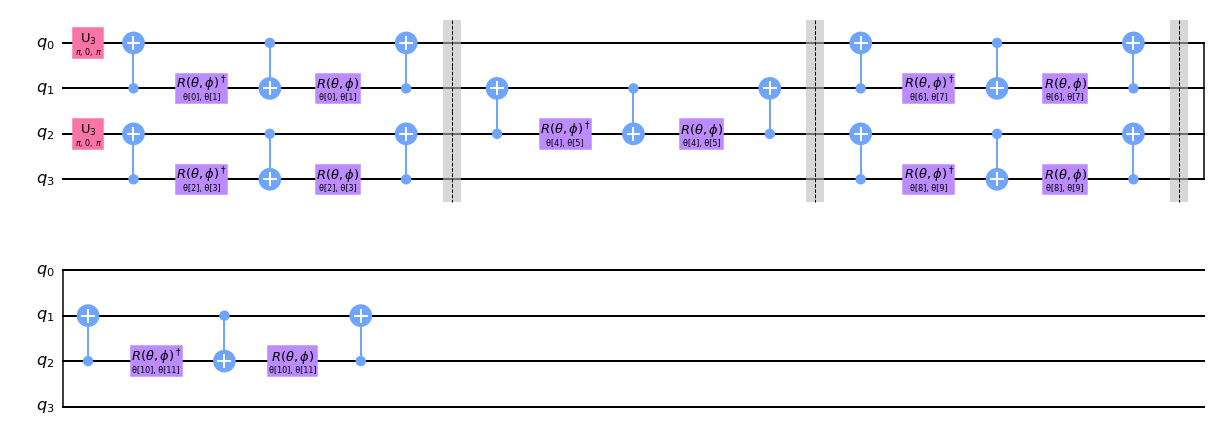

In [23]:
ansatz.decompose().draw("mpl")

In [145]:
# print(values, min(values), max(values))

In [146]:
print(values, min(values))

[-1.859096771081576, -1.3571459554347767, -0.8026428152978982, -0.6882567401456823, -1.3844522708153986, -1.7864140592744338, -1.854248967480114, -1.8328484882328997, -1.8616753853297467, -1.8669687243055542, -1.8634171465751046, -1.8838189372164855, -1.8731982316450035, -1.866917682875754, -1.8748576913394657, -1.8794134926732906, -1.8572188993567509, -1.89192631628076, -1.8683417167299208, -1.8683076891100543, -1.864103642787288, -1.871674882430008, -1.8730819024742411, -1.8813906797589444, -1.881138240108715, -1.8661801452337707, -1.8678055773083666, -1.8892796467928559, -1.8739527830969198, -1.867938920289062, -1.8490043474150375, -1.377598927841236, -0.8385821990853479, -0.665477920737037, -1.3798570189548511, -1.8075226109080447, -1.8228962112209324, -1.814504860968162, -1.8395051030949578, -1.8666318492567107, -1.8582913440048765, -1.8608508040961145, -1.8568185043522398, -1.8564152825204663, -1.883554760288988, -1.8624424992206403, -1.8772007113976534, -1.8671793897739113, -1.8

In [147]:
print(params)

[array([0.01, 0.01]), array([1.01, 0.01]), array([0.01, 1.01]), array([-0.41915112, -0.89323271]), array([-0.20457556, -0.44161635]), array([ 0.25319692, -0.04792461]), array([-1.63281708e-04,  2.59793330e-01]), array([-0.11432924, -0.00293209]), array([0.01235112, 0.07245576]), array([0.043579 , 0.0712802]), array([0.10481706, 0.0837762 ]), array([0.02904157, 0.09894291]), array([0.01965179, 0.12874886]), array([0.01413859, 0.09424802]), array([0.06029156, 0.09896656]), array([0.02060583, 0.08579077]), array([0.03673321, 0.09757407]), array([0.02279517, 0.10363522]), array([0.01702489, 0.09836843]), array([0.02537708, 0.11100874]), array([0.02408613, 0.10732198]), array([0.02142645, 0.10224191]), array([0.02449476, 0.10267287]), array([0.0226861 , 0.10460567]), array([0.02239557, 0.10335461]), array([0.02327145, 0.10352761]), array([0.02270586, 0.10386243]), array([0.02274294, 0.10354994]), array([0.02283781, 0.1036091 ]), array([0.02271396, 0.10369357]), array([0.01, 0.01]), array([1

In [148]:
print(a_total_ground_state_energies, min(a_total_ground_state_energies))

[-1.867938920289062, -1.8698279711125312, -1.8558961805624308, -1.8600873791401114, -1.8526672143233713, -1.8459292404434717, -1.8343466826101422] -1.8698279711125312


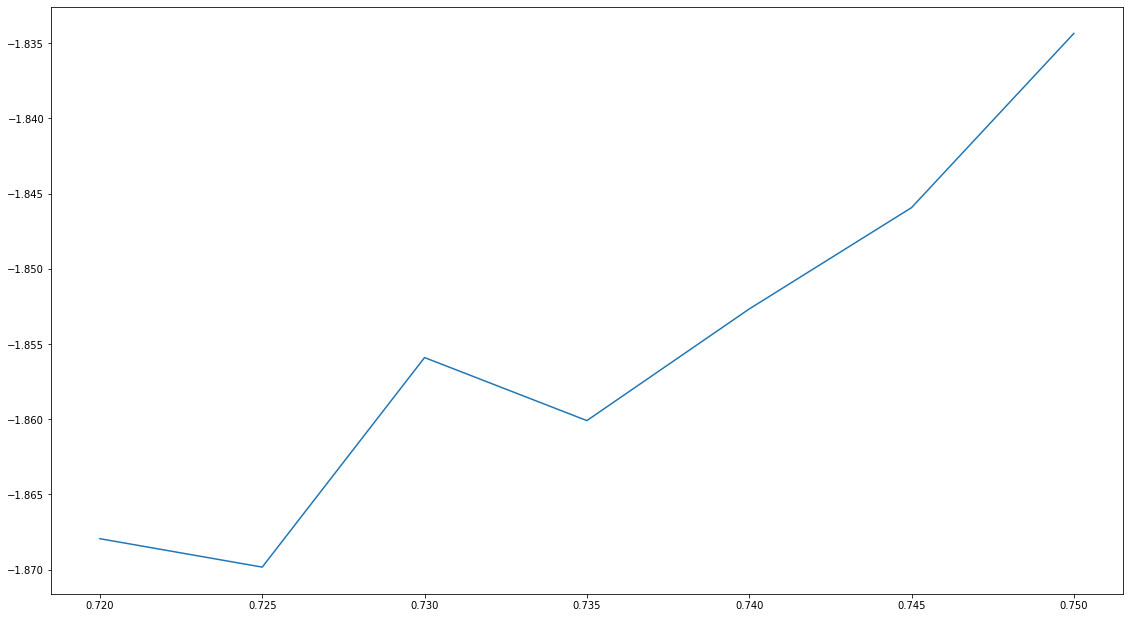

In [149]:
fig, ax = plt.subplots(1, 1, figsize=(19.20, 10.80))
# plt.plot(inter_atomic_dists, numpy_minimum_solver_total_ground_state_energies)
# plt.plot(inter_atomic_dists, numpy_eigensolver_total_ground_state_energies)
plt.plot(inter_atomic_dists, a_total_ground_state_energies)
# plt.plot(counts, values)
plt.show()